In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [27]:
data = pd.read_csv("AmesHousing.tsv", delimiter='\t')
data.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [28]:
data.dtypes.value_counts()

object     43
int64      28
float64    11
dtype: int64

In [29]:
numeric_data = data.select_dtypes(include=['float64', 'int64'])
numeric_data.dtypes.value_counts()

int64      28
float64    11
dtype: int64

In [30]:
numeric_data.isnull().sum()

Order                0
PID                  0
MS SubClass          0
Lot Frontage       490
Lot Area             0
Overall Qual         0
Overall Cond         0
Year Built           0
Year Remod/Add       0
Mas Vnr Area        23
BsmtFin SF 1         1
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
1st Flr SF           0
2nd Flr SF           0
Low Qual Fin SF      0
Gr Liv Area          0
Bsmt Full Bath       2
Bsmt Half Bath       2
Full Bath            0
Half Bath            0
Bedroom AbvGr        0
Kitchen AbvGr        0
TotRms AbvGrd        0
Fireplaces           0
Garage Yr Blt      159
Garage Cars          1
Garage Area          1
Wood Deck SF         0
Open Porch SF        0
Enclosed Porch       0
3Ssn Porch           0
Screen Porch         0
Pool Area            0
Misc Val             0
Mo Sold              0
Yr Sold              0
SalePrice            0
dtype: int64

In [31]:
def transform_features(df):
    cutoff = .25 * len(df)
    missing_values = df.isnull().sum()
    drop_columns = []
    for col in df.columns:
        if missing_values[col] > cutoff:
            drop_columns.append(col)
            
    train = df.drop(drop_columns, axis=1)
    
    replace = .05 * len(train)
    new_missing_values = train.isnull().sum()
    for col in train.columns:
        if new_missing_values[col] > 0 and new_missing_values[col] < replace:
            values = sorted(train[col].value_counts())
            train[col] = train[col].fillna(values[0])
        elif new_missing_values[col] > 0:
            train[col] = train[col].fillna(train[col].mean())
    return train

In [57]:
def select_features(train):
    corrs = train.corr()['SalePrice']
    columns = []
    for i in range(0, len(corrs)):
        if abs(corrs[i]) > .4:
            columns.append(corrs.index[i])
    columns.remove('SalePrice')
    return columns, 'SalePrice'

In [55]:
def train_and_test(df, k=0):
    features, target = select_features(df)
    model = LinearRegression()
    if k == 0:
        train = df[:1460]
        test = df[1460:]
        model.fit(train[features], train[target])
        preds = model.predict(test[features])
        rmse = mean_squared_error(preds, test[target]) ** (1/2)
    elif k == 1:
        new_index = np.random.permutation(df.index)
        df = df.reset_index(new_index)
        fold_one = df[:1460]
        fold_two = df[1460:]
        model.fit(fold_one[features], fold_one[target])
        preds = model.predict(fold_two[features])
        f1_rmse = mean_squared_error(preds, fold_two[target]) ** (1/2)
        model.fit(fold_two[features], fold_two[target])
        preds = model.predict(fold_one[features])
        f2_rmse = mean_squared_error(preds, fold_one[target]) ** (1/2)
        rmse = (f1_rmse + f2_rmse) / 2
    else:
        kf = KFold(n_splits=k, shuffle=True)
        rmse_values = []
        for train_index, test_index, in kf.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            model.fit(train[features], train[target])
            predictions = model.predict(test[features])
            mse = mean_squared_error(test[target], predictions)
            rmse_val = np.sqrt(mse)
            rmse_values.append(rmse_val)
        # print(rmse_values)
        rmse = np.mean(rmse_values)
    return rmse

In [34]:
numeric_data = transform_features(numeric_data)

In [35]:
numeric_data.isnull().sum()

Order              0
PID                0
MS SubClass        0
Lot Frontage       0
Lot Area           0
Overall Qual       0
Overall Cond       0
Year Built         0
Year Remod/Add     0
Mas Vnr Area       0
BsmtFin SF 1       0
BsmtFin SF 2       0
Bsmt Unf SF        0
Total Bsmt SF      0
1st Flr SF         0
2nd Flr SF         0
Low Qual Fin SF    0
Gr Liv Area        0
Bsmt Full Bath     0
Bsmt Half Bath     0
Full Bath          0
Half Bath          0
Bedroom AbvGr      0
Kitchen AbvGr      0
TotRms AbvGrd      0
Fireplaces         0
Garage Yr Blt      0
Garage Cars        0
Garage Area        0
Wood Deck SF       0
Open Porch SF      0
Enclosed Porch     0
3Ssn Porch         0
Screen Porch       0
Pool Area          0
Misc Val           0
Mo Sold            0
Yr Sold            0
SalePrice          0
dtype: int64

In [36]:
numeric_data = numeric_data.drop('Garage Yr Blt', axis=1)

In [37]:
numeric_data = numeric_data.drop(['Yr Sold', 'Mo Sold'], axis=1)

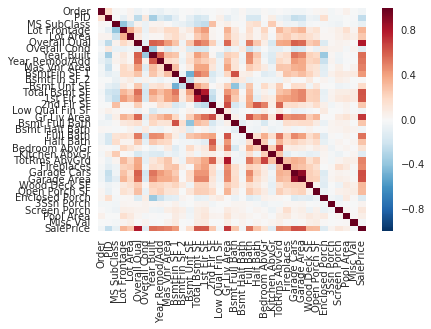

In [38]:
sns.heatmap(numeric_data.corr())

In [39]:
corr_cols = ['Overall Qual', 'Year Built', 'Total Bsmt SF', '1st Flr SF', 'Gr Liv Area', 'Full Bath', 'TotRms AbvGrd', 'Garage Area', 'SalePrice']
nums = numeric_data[corr_cols].corr()['SalePrice']

In [58]:
features, target = select_features(numeric_data)

In [59]:
features

['Overall Qual',
 'Year Built',
 'Year Remod/Add',
 'Mas Vnr Area',
 'BsmtFin SF 1',
 'Total Bsmt SF',
 '1st Flr SF',
 'Gr Liv Area',
 'Full Bath',
 'TotRms AbvGrd',
 'Fireplaces',
 'Garage Cars',
 'Garage Area']

In [60]:
ks = [0, 1, 2, 3, 5, 8, 12, 15, 20, 25, 35, 50, 100]

for i in ks:
    print("k=" + str(i) + ": " + str(train_and_test(numeric_data, k=i)))

k=0: 40685.2754347
k=1: 36366.2506643
k=2: 35463.7266151
k=3: 36160.8803617
k=5: 35022.4803403
k=8: 35180.8595213
k=12: 34674.5472095
k=15: 34574.0363227
k=20: 33820.700163
k=25: 33986.405412
k=35: 33589.7364695
k=50: 32853.967807
k=100: 31997.3285797
